## Import libs and data

In [2]:
import pandas as pd
import re
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm, tqdm_notebook, trange
tqdm.pandas()
from collections import Counter
import pickle
import squarify
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# load dataframe of post and corresponding tokens
df_post = pd.read_csv('../out/car/df_post.csv')

with open('../out/car/tokens_post.txt', 'rb') as fp:
    tokens_post = pickle.load(fp)

df_post['user_id'] = df_post['user_id'].astype(int)

In [4]:
# load user x tag file
df_user_x_cat = pd.read_csv('../src/pantip_user_cat.csv')

In [5]:
df_user_x_cat.head()

,user_id,category,post_date
0,4179868,travel,2018-12-06 21:31:06
1,2897151,travel,2018-12-06 21:19:04
2,772076,travel,2018-12-06 20:52:07
3,4977690,travel,2018-12-06 20:24:25
4,2239672,travel,2018-12-06 20:03:01


In [6]:
df_user_x_cat.category.nunique()

5915

In [7]:
# select top 500 most popular categories
cat_counter = Counter(df_user_x_cat.category.values)

## create tags set and prepare dataframe

In [8]:
# create list of tags
tag_list=[]
for text in df_user_x_cat.category:
    tag_list.append(text.split(', '))

all_tags = []
for tl in tag_list:
    for tag in tl:
        if not tag in all_tags:
            all_tags.append(tag)

In [9]:
all_tags

['travel',
 'auto',
 'pantip_food',
 'pantip_cartoon',
 'pantip_chalermthai',
 'pantip_chalermkrung',
 'pantip_korea',
 'pantip_gadget',
 'pantip_siliconvalley',
 'pantip_family',
 'pantip_rajdumnern',
 'pantip_social',
 'pantip_klaibann',
 'pantip_home',
 'pantip_tvshow',
 'pantip_region',
 'pantip_mbk',
 'pantip_supachalasai',
 'pantip_lumpini',
 'pantip_sinthorn',
 'pantip_wahkor',
 'pantip_library',
 'pantip_siam',
 'pantip_beauty',
 'pantip_bangrak']

In [ ]:
df_tags = pd.DataFrame(np.zeros((len(tag_list),len(all_tags))),columns=all_tags)

for i in tqdm_notebook(range(len(tag_list))):
    for tag in tag_list[i]:
        df_tags.loc[i,tag] = 1

df_tags['user_id'] = df_user_x_cat.user_id.values

df_tags.to_csv('../tmp/df_tags.csv',index=False)

In [11]:
df_tags = pd.read_csv('../tmp/df_tags.csv')

In [12]:
df_user_segment = df_tags.groupby('user_id').sum()
df_user_segment.head()

,travel,auto,pantip_food,pantip_cartoon,pantip_chalermthai,pantip_chalermkrung,pantip_korea,pantip_gadget,pantip_siliconvalley,pantip_family,pantip_rajdumnern,pantip_social,pantip_klaibann,pantip_home,pantip_tvshow,pantip_region,pantip_mbk,pantip_supachalasai,pantip_lumpini,pantip_sinthorn,pantip_wahkor,pantip_library,pantip_siam,pantip_beauty,pantip_bangrak
user_id,,,,,,,,,,,,,,,,,,,,,,,,,
4,3.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0


In [13]:
df_user_segment = df_user_segment.div(df_user_segment.sum(axis=1), axis=0)

## Performing segmentation

In [14]:
# filter unique user id based on kws
kws = ['yaris','ativ']

idxs=[]
for i,tkn in enumerate(tokens_post):
    for kw in kws:
        if kw in tkn:
            idxs.append(i)
            break
            
df_temp = df_post.iloc[idxs]

unique_user = df_temp.user_id.unique()

print('total unique user:',len(unique_user))

total unique user: 2210


In [15]:
df_user_segment_filt = df_user_segment.loc[unique_user]

In [16]:
sc = StandardScaler()
user_segment_sc = sc.fit_transform(df_user_segment_filt)

## experiment with K-mean clustering

In [30]:
labels = []
wcss = []
for i in trange(1,21):
    k_model = KMeans(n_clusters=i,)
    labels.append(k_model.fit_predict(user_segment_sc))
    wcss.append(k_model.inertia_)

100%|██████████| 20/20 [00:04<00:00,  3.58it/s]


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

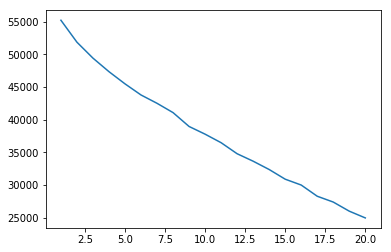

In [32]:
plt.plot(range(1,21),wcss)

## experiment with DBScan

In [17]:
from sklearn.cluster import DBSCAN

In [18]:
# first check distance to nearest neighbor
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2,metric='cosine').fit(user_segment_sc)

In [19]:
distances, _ = nbrs.kneighbors(user_segment_sc)

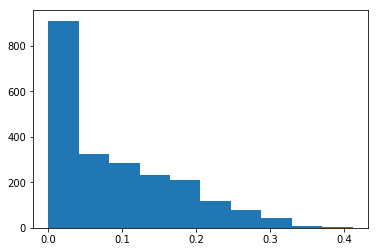

In [20]:
_=plt.hist(distances[:,1])

In [21]:
np.median(distances[:,1])

0.06777602560624979

In [22]:
dbscan = DBSCAN(eps=0.20, min_samples=10,n_jobs=-1,metric='cosine')

label = dbscan.fit_predict(user_segment_sc)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(label)) - (1 if -1 in label else 0)
n_noise_ = list(label).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

pd.value_counts(label)

Estimated number of clusters: 6
Estimated number of noise points: 448


 0    1541
-1     448
 2     101
 5      37
 3      33
 1      32
 4      18
dtype: int64

In [23]:
df_user_segment_filt.head()

,travel,auto,pantip_food,pantip_cartoon,pantip_chalermthai,pantip_chalermkrung,pantip_korea,pantip_gadget,pantip_siliconvalley,pantip_family,pantip_rajdumnern,pantip_social,pantip_klaibann,pantip_home,pantip_tvshow,pantip_region,pantip_mbk,pantip_supachalasai,pantip_lumpini,pantip_sinthorn,pantip_wahkor,pantip_library,pantip_siam,pantip_beauty,pantip_bangrak
user_id,,,,,,,,,,,,,,,,,,,,,,,,,
250736,0.336957,0.076087,0.076087,0.005435,0.005435,0.000000,0.0,0.0,0.005435,0.021739,0.0,0.010870,0.038043,0.103261,0.0,0.000000,0.054348,0.0,0.038043,0.206522,0.0,0.005435,0.010870,0.005435,0.000000
4992439,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4992206,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
603108,0.078947,0.052632,0.000000,0.000000,0.000000,0.052632,0.0,0.0,0.000000,0.052632,0.0,0.078947,0.000000,0.210526,0.0,0.078947,0.026316,0.0,0.105263,0.026316,0.0,0.000000,0.157895,0.026316,0.052632
4982252,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [24]:
'''
NEXT STEP:
describe profile of each segment
'''
df_user_segment_filt['segment_id'] = label

# summary statistic by segment
df_segment = df_user_segment_filt.groupby('segment_id')[all_tags].mean()

df_user_segment_filt.reset_index(inplace=True)

df_segment = df_segment.join(df_user_segment_filt.groupby('segment_id')['user_id'].count()).rename({'user_id':'total_user'},axis=1)

In [25]:
df_segment

,travel,auto,pantip_food,pantip_cartoon,pantip_chalermthai,pantip_chalermkrung,pantip_korea,pantip_gadget,pantip_siliconvalley,pantip_family,pantip_rajdumnern,pantip_social,pantip_klaibann,pantip_home,pantip_tvshow,pantip_region,pantip_mbk,pantip_supachalasai,pantip_lumpini,pantip_sinthorn,pantip_wahkor,pantip_library,pantip_siam,pantip_beauty,pantip_bangrak,total_user
segment_id,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,0.069138,0.221640,0.028532,0.006292,0.019373,0.020487,0.003601,0.002987,0.061402,0.028333,0.008979,0.068697,0.012282,0.052139,0.012372,0.023796,0.109188,0.030995,0.061054,0.068475,0.016689,0.020104,0.042576,0.005528,0.005340,448
0,0.051701,0.472227,0.016462,0.001686,0.011245,0.008225,0.000128,0.002267,0.048074,0.020852,0.001957,0.030858,0.008099,0.042677,0.003488,0.016566,0.097243,0.031910,0.028495,0.066372,0.003281,0.004890,0.025439,0.001330,0.004528,1541
1,0.029591,0.220712,0.027711,0.180766,0.054006,0.019102,0.001106,0.001193,0.062948,0.012801,0.007944,0.048558,0.002350,0.021896,0.012528,0.004661,0.105525,0.031116,0.017332,0.022321,0.023547,0.016165,0.069569,0.003183,0.003370,32
2,0.042746,0.254371,0.016833,0.004935,0.009165,0.007186,0.000066,0.000691,0.051274,0.010779,0.005301,0.054227,0.006107,0.032488,0.005389,0.014423,0.060263,0.022108,0.033421,0.046084,0.116386,0.132812,0.069727,0.001552,0.001667,101
3,0.044483,0.197198,0.007368,0.002331,0.016117,0.013481,0.000000,0.000941,0.023936,0.006727,0.388502,0.025447,0.017607,0.032367,0.004768,0.006439,0.078712,0.044162,0.010891,0.040964,0.024978,0.004264,0.006409,0.001909,0.000000,33
4,0.036842,0.227091,0.010728,0.000561,0.025267,0.013466,0.002874,0.000000,0.035193,0.000748,0.001991,0.043280,0.002092,0.025291,0.351368,0.005233,0.078755,0.031946,0.028651,0.037865,0.010255,0.004081,0.025301,0.001122,0.000000,18
5,0.076074,0.230480,0.032529,0.008076,0.002461,0.005825,0.000000,0.000000,0.025574,0.040680,0.000000,0.085968,0.009106,0.042236,0.002354,0.040255,0.089327,0.015607,0.091747,0.052392,0.001077,0.011481,0.031634,0.103030,0.002090,37


In [26]:
segment_lst = df_segment.columns[:-1]

# find top 3 traits for each segment
seg_character = []
for seg_id in df_segment.index:
    seg_dict = dict()
    top_3 = np.argsort(df_segment.loc[seg_id].values[:-1])[-3:]
    for i in range(2, -1,-1):
        seg_dict[segment_lst[top_3[i]]] = df_segment.loc[seg_id].values[top_3[i]]
    seg_character.append(seg_dict)

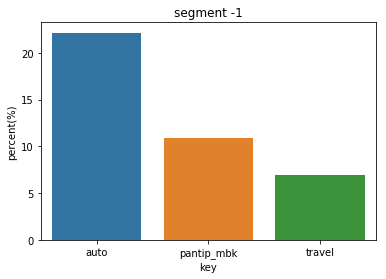

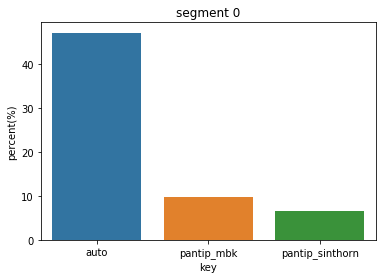

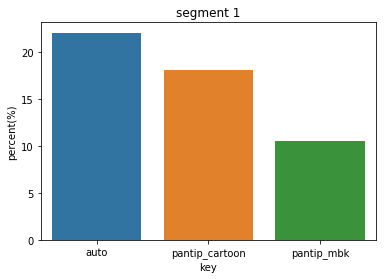

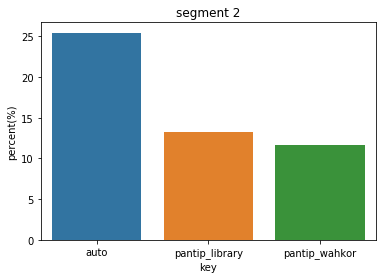

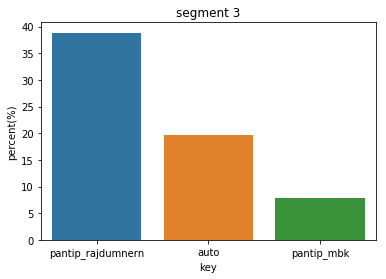

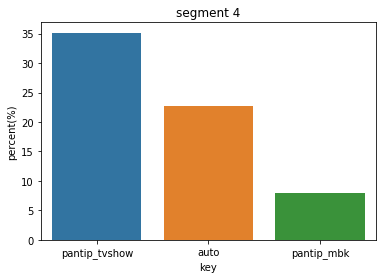

In [38]:
# visualize segment character
for i in range(n_clusters_):
    df_plot = pd.DataFrame({'key':list(seg_character[i].keys()),'percent(%)':list(seg_character[i].values())})
    df_plot['percent(%)']=df_plot['percent(%)']*100
    sns.barplot(x='key',y='percent(%)',data=df_plot,).set_title(f'segment {df_segment.index[i]}')
    plt.show()
    df_plot.to_csv(f'../tmp/segment_{df_segment.index[i]}.csv',index=False)

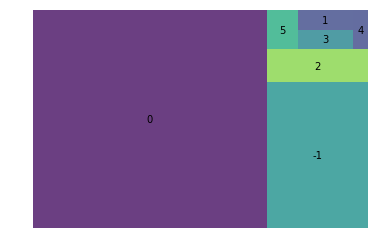

In [31]:
squarify.plot(sizes=df_user_segment_filt.segment_id.value_counts().values, label=df_user_segment_filt.segment_id.value_counts().index, alpha=.8 )
_=plt.axis('off')

In [37]:
segment_pop = df_user_segment_filt.segment_id.value_counts().reset_index()
segment_pop.columns = ['segment_id','population']
segment_pop.to_csv('../tmp/segment_pop.csv',index=False)